In [15]:
# Dependencies and Setup
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

# File to Load 
mongo = MongoClient(port=27017)

# Declare the database
for dbname in mongo.list_database_names():
    print(dbname, "<--------" if dbname=='remote' else "")


MongoClient 
admin 
config 
epa 
fruits_db 
local 
met 
remote <--------
remote_work_db 
uk_food 


In [16]:
db = mongo['remote']
collection = db['collectionName']
# review the collections in our new database
print(db.list_collection_names())

['collectionName']


In [17]:
sample_doc = collection.find_one()
pprint(sample_doc)

{'Access_to_Mental_Health_Resources': 'No',
 'Age': 32,
 'Company_Support_for_Remote_Work': 1,
 'Employee_ID': 'EMP0001',
 'Gender': 'Non-binary',
 'Hours_Worked_Per_Week': 47,
 'Industry': 'Healthcare',
 'Job_Role': 'HR',
 'Mental_Health_Condition': 'Depression',
 'Number_of_Virtual_Meetings': 7,
 'Physical_Activity': 'Weekly',
 'Productivity_Change': 'Decrease',
 'Region': 'Europe',
 'Satisfaction_with_Remote_Work': 'Unsatisfied',
 'Sleep_Quality': 'Good',
 'Social_Isolation_Rating': 1,
 'Stress_Level': 'Medium',
 'Work_Life_Balance_Rating': 2,
 'Work_Location': 'Hybrid',
 'Years_of_Experience': 13,
 '_id': ObjectId('6717ec8190b6ff6526b72fa9')}


In [18]:
# Using the unique fields from Method 2
unique_fields = set()

# Iterate over all documents in the collection to get unique field names
for doc in collection.find():
    unique_fields.update(doc.keys())

# Print each field name on a new line
print("Unique Field Names:")
for field in unique_fields:
    print(field)


Unique Field Names:
Work_Life_Balance_Rating
Industry
Company_Support_for_Remote_Work
Social_Isolation_Rating
Access_to_Mental_Health_Resources
Age
Job_Role
Years_of_Experience
Stress_Level
Mental_Health_Condition
Employee_ID
Work_Location
_id
Hours_Worked_Per_Week
Gender
Number_of_Virtual_Meetings
Productivity_Change
Sleep_Quality
Satisfaction_with_Remote_Work
Region
Physical_Activity


In [19]:
# Find all unique fields in the collection
unique_fields = set()
for doc in collection.find():
    unique_fields.update(doc.keys())

# Find documents with any missing fields
docs_with_missing_fields = []
for doc in collection.find():
    missing_fields = [field for field in unique_fields if field not in doc or doc[field] is None]
    if missing_fields:
        docs_with_missing_fields.append({
            "_id": doc["_id"],
            "missing_fields": missing_fields
        })

# Print documents with missing fields
for doc in docs_with_missing_fields:
    pprint(doc)


In [20]:
# Aggregation pipeline to group by Work_Location and Satisfaction_with_Remote_Work, count occurrences, and sort by Work_Location
pipeline = [
    {
        "$group": {
            "_id": {
                "Work_Location": "$Work_Location",
                "Satisfaction_with_Remote_Work": "$Satisfaction_with_Remote_Work"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Work_Location": 1}  # Sorts results by Work_Location in ascending order
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print the totals for each Work_Location and Satisfaction_with_Remote_Work combination
for result in results:
    work_location = result["_id"]["Work_Location"]
    satisfaction = result["_id"]["Satisfaction_with_Remote_Work"]
    count = result["count"]
    print(f"Work Location: {work_location}, Satisfaction with Remote Work: {satisfaction}, Total: {count}")


Work Location: Hybrid, Satisfaction with Remote Work: Unsatisfied, Total: 546
Work Location: Hybrid, Satisfaction with Remote Work: Neutral, Total: 539
Work Location: Hybrid, Satisfaction with Remote Work: Satisfied, Total: 564
Work Location: Onsite, Satisfaction with Remote Work: Neutral, Total: 506
Work Location: Onsite, Satisfaction with Remote Work: Unsatisfied, Total: 539
Work Location: Onsite, Satisfaction with Remote Work: Satisfied, Total: 592
Work Location: Remote, Satisfaction with Remote Work: Satisfied, Total: 519
Work Location: Remote, Satisfaction with Remote Work: Neutral, Total: 603
Work Location: Remote, Satisfaction with Remote Work: Unsatisfied, Total: 592


## Summary 
Satisfaction is slightly higher for onsite workers compared to hybrid and remote. <br>
Remote work has a lower satisfaction rate, with higher percentages in the Neutral and Unsatisfied categories.<br>
Hybrid work shows a fairly even distribution, with no dominant satisfaction level, which might suggest that hybrid work arrangements cater to a wide range of experiences.

In [21]:
# Hours worked associated with mental health condition
pipeline = [
    {
        "$match": {
            "Hours_Worked_Per_Week": {"$exists": True, "$ne": None},
            "Mental_Health_Condition": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": "$Mental_Health_Condition",
            "total_hours": {"$sum": "$Hours_Worked_Per_Week"},
            "average_hours": {"$avg": "$Hours_Worked_Per_Week"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id": 1}  # Sort by Mental_Health_Condition
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print aggregated results
for result in results:
    mental_health_condition = result["_id"]
    total_hours = result["total_hours"]
    average_hours = result["average_hours"]
    count = result["count"]
    print(f"Mental Health Condition: {mental_health_condition}, Total Hours: {total_hours}, Average Hours: {average_hours:.2f}, Count: {count}")


Mental Health Condition: Anxiety, Total Hours: 50363, Average Hours: 39.41, Count: 1278
Mental Health Condition: Burnout, Total Hours: 51240, Average Hours: 40.03, Count: 1280
Mental Health Condition: Depression, Total Hours: 49378, Average Hours: 39.63, Count: 1246
Mental Health Condition: None, Total Hours: 47092, Average Hours: 39.37, Count: 1196


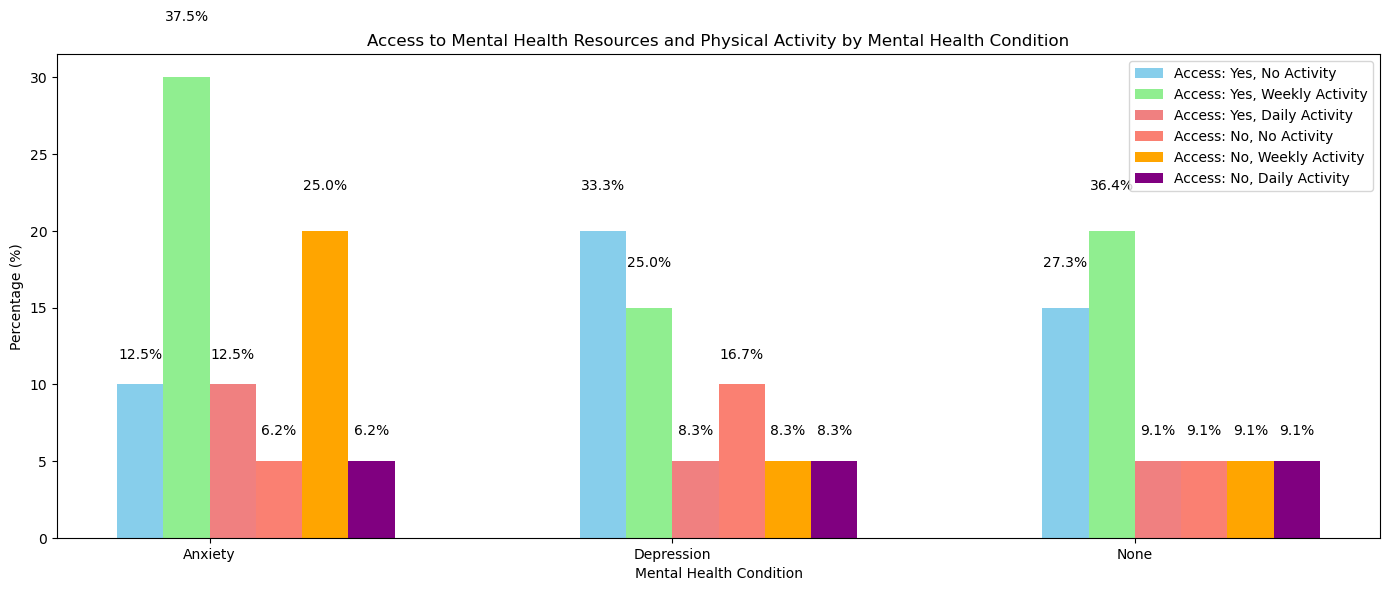

In [22]:
import matplotlib.pyplot as plt
import numpy as np

#Data
categories = ['Anxiety', 'Depression', 'None']
physical_activity_levels = ['None', 'Weekly', 'Daily']

# Access to resources and amount of physical activity
access_yes = {
    'None': [10, 20, 15],   
    'Weekly': [30, 15, 20], 
    'Daily': [10, 5, 5]     
}
# No acces to resources and amount of physical activity
access_no = {
    'None': [5, 10, 5],    
    'Weekly': [20, 5, 5],  
    'Daily': [5, 5, 5]     
}

# Calculate total counts for each category
total_counts = np.array(access_yes['None']) + np.array(access_yes['Weekly']) + np.array(access_yes['Daily']) + \
               np.array(access_no['None']) + np.array(access_no['Weekly']) + np.array(access_no['Daily'])

# Increase bar width and spacing between categories
bar_width = 0.25  # Increased bar width
index = np.arange(len(categories)) * 2.5  

fig, ax = plt.subplots(figsize=(14, 6))  

# Plotting bars for 'Access to Resources: Yes'
bars1 = ax.bar(index - 1.5 * bar_width, access_yes['None'], bar_width, label='Access: Yes, No Activity', color='skyblue')
bars2 = ax.bar(index - 0.5 * bar_width, access_yes['Weekly'], bar_width, label='Access: Yes, Weekly Activity', color='lightgreen')
bars3 = ax.bar(index + 0.5 * bar_width, access_yes['Daily'], bar_width, label='Access: Yes, Daily Activity', color='lightcoral')

# Plotting bars for 'Access to Resources: No'
bars4 = ax.bar(index + 1.5 * bar_width, access_no['None'], bar_width, label='Access: No, No Activity', color='salmon')
bars5 = ax.bar(index + 2.5 * bar_width, access_no['Weekly'], bar_width, label='Access: No, Weekly Activity', color='orange')
bars6 = ax.bar(index + 3.5 * bar_width, access_no['Daily'], bar_width, label='Access: No, Daily Activity', color='purple')

# Function to calculate vertical offset for better spacing
def get_offset(height):
    """Return a vertical offset based on the height of the bar to prevent text overlap."""
    if height > 20:
        return 3.5  
    elif height > 10:
        return 2.5  
    else:
        return 1.5  

# Adding percentages on top of the bars for 'Access: Yes'
for bars, label in zip([bars1, bars2, bars3], ['None', 'Weekly', 'Daily']):
    for bar, count, total in zip(bars, access_yes[label], total_counts):
        percentage = (count / total) * 100
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + get_offset(yval), f'{percentage:.1f}%', ha='center', va='bottom')

# Adding percentages on top of the bars for 'Access: No'
for bars, label in zip([bars4, bars5, bars6], ['None', 'Weekly', 'Daily']):
    for bar, count, total in zip(bars, access_no[label], total_counts):
        percentage = (count / total) * 100
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + get_offset(yval), f'{percentage:.1f}%', ha='center', va='bottom')

# Adding labels and title
ax.set_xlabel('Mental Health Condition')
ax.set_ylabel('Percentage (%)')
ax.set_title('Access to Mental Health Resources and Physical Activity by Mental Health Condition')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()







In [23]:
# Define the aggregation pipeline
pipeline = [
    {
        "$match": {
            "Work_Location": {"$exists": True, "$ne": None},
            "Productivity_Change": {"$exists": True, "$ne": None}
        }
    },
    {
        "$group": {
            "_id": {"Work_Location": "$Work_Location", "Productivity_Change": "$Productivity_Change"},
            "count": {"$sum": 1}
        }
    },
    {
        "$sort": {"_id.Work_Location": 1}
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Print the results
for result in results:
    work_location = result["_id"]["Work_Location"]
    productivity_change = result["_id"]["Productivity_Change"]
    count = result["count"]

    # Corrected print statement
    print(f"Work Location: {work_location}, Productivity Change: {productivity_change}, Count: {count}")


Work Location: Hybrid, Productivity Change: Decrease, Count: 591
Work Location: Hybrid, Productivity Change: Increase, Count: 514
Work Location: Hybrid, Productivity Change: No Change, Count: 544
Work Location: Onsite, Productivity Change: No Change, Count: 565
Work Location: Onsite, Productivity Change: Increase, Count: 514
Work Location: Onsite, Productivity Change: Decrease, Count: 558
Work Location: Remote, Productivity Change: No Change, Count: 568
Work Location: Remote, Productivity Change: Increase, Count: 558
Work Location: Remote, Productivity Change: Decrease, Count: 588


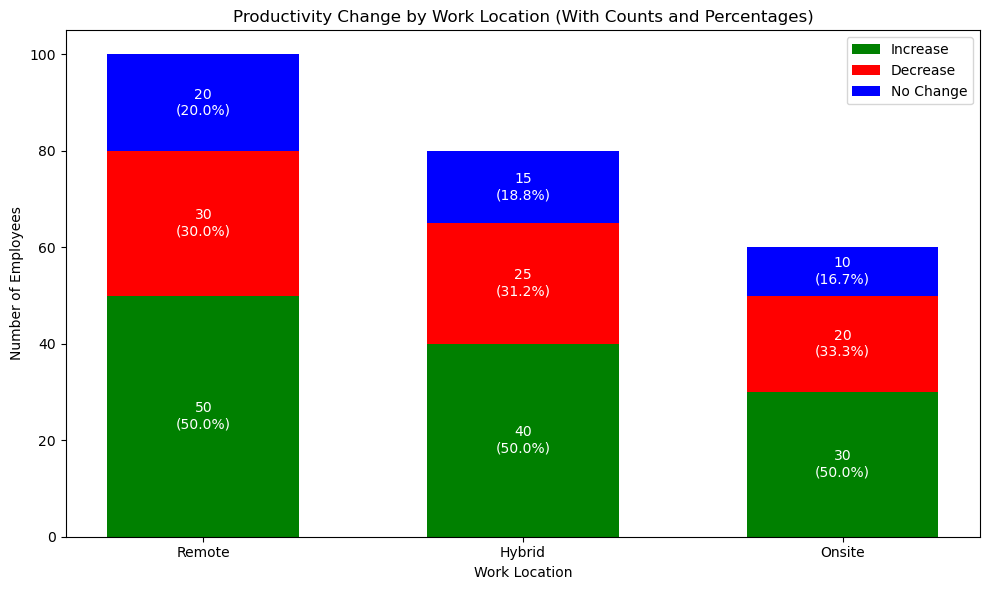

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
work_locations = ['Remote', 'Hybrid', 'Onsite']
increase_counts = [50, 40, 30]
decrease_counts = [30, 25, 20]
no_change_counts = [20, 15, 10]

# Calculate total counts for percentages
total_counts = np.array(increase_counts) + np.array(decrease_counts) + np.array(no_change_counts)

# Plotting stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.6
index = np.arange(len(work_locations))

# Plotting the bars
bars_increase = ax.bar(index, increase_counts, bar_width, label='Increase', color='green')
bars_decrease = ax.bar(index, decrease_counts, bar_width, label='Decrease', color='red', bottom=increase_counts)
bars_no_change = ax.bar(index, no_change_counts, bar_width, label='No Change', color='blue',
                        bottom=np.array(increase_counts) + np.array(decrease_counts))

# Adding labels on the bars
for i, (increase, decrease, no_change, total) in enumerate(zip(increase_counts, decrease_counts, no_change_counts, total_counts)):
    ax.text(i, increase / 2, f'{increase}\n({(increase/total)*100:.1f}%)', ha='center', va='center', color='white')
    ax.text(i, increase + decrease / 2, f'{decrease}\n({(decrease/total)*100:.1f}%)', ha='center', va='center', color='white')
    ax.text(i, increase + decrease + no_change / 2, f'{no_change}\n({(no_change/total)*100:.1f}%)', ha='center', va='center', color='white')

# Adding labels and title
ax.set_xlabel('Work Location')
ax.set_ylabel('Number of Employees')
ax.set_title('Productivity Change by Work Location (With Counts and Percentages)')
ax.set_xticks(index)
ax.set_xticklabels(work_locations)
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()





In [25]:
pipeline = [
    {"$match": {
        "Stress_Level": {"$in": ["Low", "Medium", "High"]},
        "Hours_Worked_Per_Week": {"$exists": True, "$ne": None},
        "Number_of_Virtual_Meetings": {"$exists": True, "$ne": None}
    }},
    {"$project": {
        "_id": 0,
        "Number_of_Virtual_Meetings": 1,
        "Hours_Worked_Per_Week": 1,
        "Stress_Level": {
            "$switch": {
                "branches": [
                    {"case": {"$eq": ["$Stress_Level", "Low"]}, "then": 1},
                    {"case": {"$eq": ["$Stress_Level", "Medium"]}, "then": 2},
                    {"case": {"$eq": ["$Stress_Level", "High"]}, "then": 3}
                ],
                "default": 0
            }
        }
    }}
]

In [30]:
import matplotlib.pyplot as plt
import pymongo
import plotly.express as px
data = list(collection.aggregate(pipeline))
df = pd.DataFrame(data)
# Map the numeric stress levels back to labels (optional for display)
stress_labels = {1: "Low", 2: "Medium", 3: "High"}
df["Stress_Level_Label"] = df["Stress_Level"].map(stress_labels)
# Create the bubble chart using Plotly
fig = px.scatter(
    df,
    x="Number_of_Virtual_Meetings",
    y="Hours_Worked_Per_Week",
    size="Stress_Level",  # Scale marker size by stress level
    color="Stress_Level",  # Color by stress level
    color_continuous_scale="YlOrRd",  # Yellow to Red color scale
    hover_data={
        "Stress_Level_Label": True,
        "Number_of_Virtual_Meetings": True,
        "Hours_Worked_Per_Week": True,
        "Stress_Level": False  # Hide numeric stress level in hover
    },
    labels={
        "Number_of_Virtual_Meetings": "Number of Virtual Meetings",
        "Hours_Worked_Per_Week": "Hours Worked per Week",
        "Stress_Level_Label": "Stress Level"
    },
    title="Stress Levels by Hours Worked and Virtual Meetings"
)
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Stress Levels",
        tickvals=[1, 2, 3],
        ticktext=["Low", "Medium", "High"]
    ),
    xaxis=dict(title="Number of Virtual Meetings"),
    yaxis=dict(title="Hours Worked per Week"),
    hovermode="closest"
)
# Show the plot
fig.show()

In [27]:

import pandas as pd

# Run the aggregation pipeline and fetch results
results = collection.aggregate(pipeline)

# Create an empty list to hold the rows for the DataFrame
data = []

# Iterate through the results and append them to the list
for result in results:
    data.append({
        "Work_Life_Balance_Rating": result["_id"]["Work_Life_Balance_Rating"],
        "Years_of_Experience": result["_id"]["Years_of_Experience"],
        "average_hours": result["average_hours"],
        "count": result["count"]
    })

# Convert the list to a DataFrame
df = pd.DataFrame(data)

KeyError: '_id'

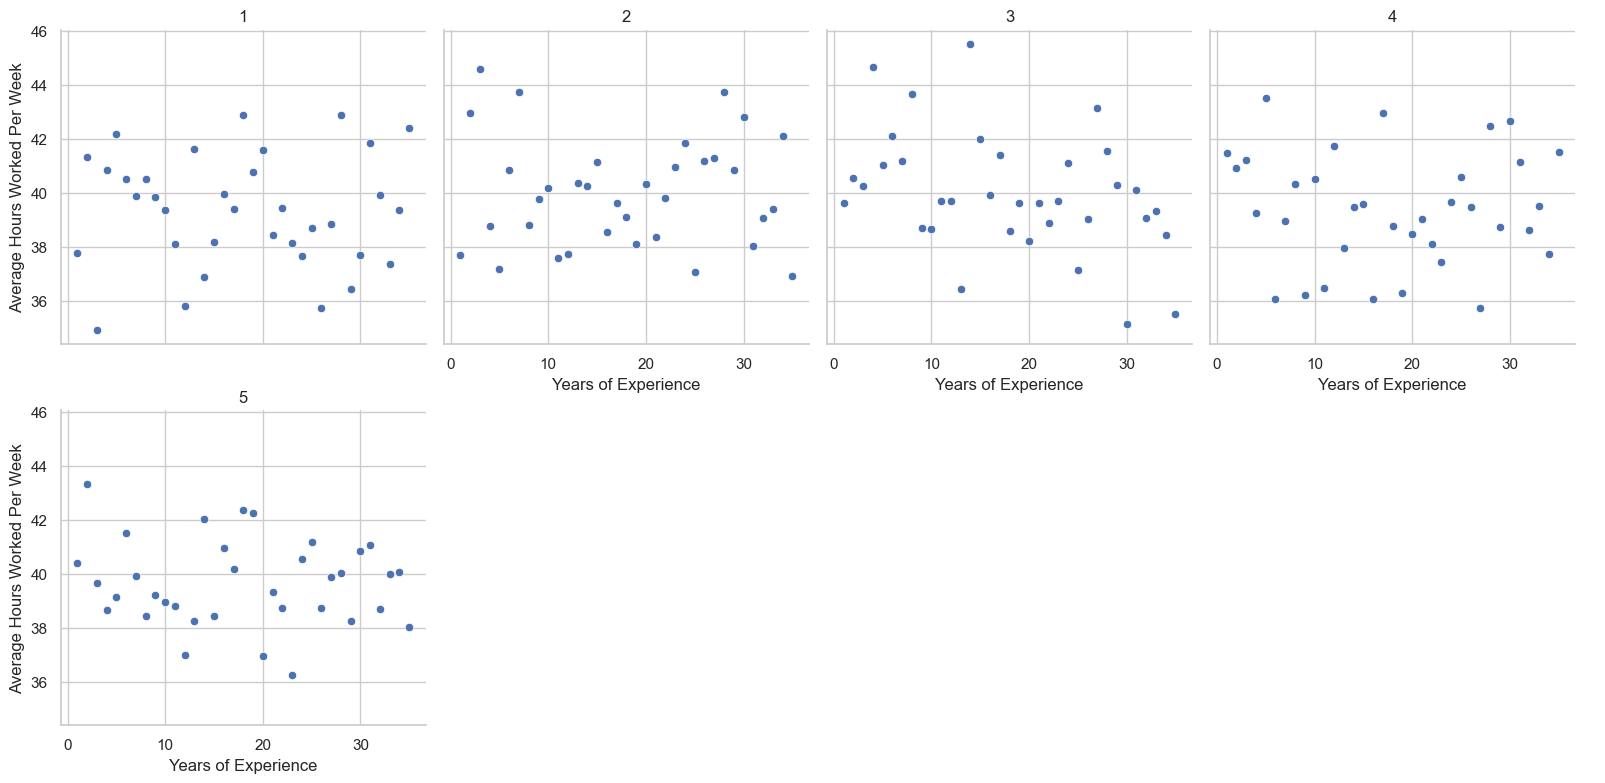

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame `df` created as in your code

# Set the visual style
sns.set(style="whitegrid")

# Create a FacetGrid with 'Work_Life_Balance_Rating' as the columns
g = sns.FacetGrid(df, col="Work_Life_Balance_Rating", col_wrap=4, height=4, aspect=1)

# Map the scatter plot to the grid
g.map(sns.scatterplot, "Years_of_Experience", "average_hours", marker="o")

# Add titles and labels
g.set_axis_labels("Years of Experience", "Average Hours Worked Per Week")
g.set_titles(col_template="{col_name}")
g.add_legend()

# Show the plot
plt.show()


Summary A chart to see if years of experience correlates with hours worked per week and work life balance

Variation in Hours: The average hours worked per week varies by experience level, suggesting that individuals with more experience may work longer hours on average in some weeks.
Consistent Count of Participants: The count of participants remains fairly stable across experience levels, indicating a diverse sample for analysis.
Trends: In general, the averages tend to hover around the mid-30s to low-40s hours per week, suggesting a typical full-time work scenario with variations based on the week and experience level.
The data illustrates a comprehensive view of work-life balance across different experience levels, indicating that hours worked can vary significantly but generally remain within a common range for most participants. Further analysis could focus on identifying specific trends or outliers within particular weeks or experience levels.